In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
import sys
import boto3
import sagemaker
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit
from sagemaker.tensorflow import TensorFlow

sys.path.append("..")
from utils.cam_utils import get_img_arr, view_img

In [3]:
config = configparser.ConfigParser()
_ = config.read(os.path.join("..", "conf", "config.ini"))

raw_data_path = config["project"]["raw_data_path"]

fc_size = eval(config["model"]["fc_size"])
img_size = eval(config["model"]["img_size"])
n_epochs = eval(config["model"]["n_epochs"])
batch_size = eval(config["model"]["batch_size"])
initial_learning_rate = eval(config["model"]["initial_learning_rate"])
first_decay_steps = eval(config["model"]["first_decay_steps"])
use_adamw = eval(config["model"]["use_adamw"])
use_swa = eval(config["model"]["use_swa"])
use_mixup = eval(config["model"]["use_mixup"])
label_smoothing = eval(config["model"]["label_smoothing"])

region = config["aws"]["region"]
bucket = config["aws"]["s3_bucket"]
prefix = config["aws"]["s3_prefix"]
role = config["aws"]["iam_role"]

label_names = {
    "c0": "safe driving",
    "c1": "texting - right",
    "c2": "talking on the phone - right",
    "c3": "texting - left",
    "c4": "talking on the phone - left",
    "c5": "operating the radio",
    "c6": "drinking",
    "c7": "reaching behind",
    "c8": "hair and makeup",
    "c9": "talking to passenger",
}

n_classes = len(label_names)

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()

if len(region) == 0:
    region = boto_session.region_name
if len(bucket) == 0:
    bucket = sagemaker_session.default_bucket()
    
account_id = boto_session.client("sts").get_caller_identity().get("Account")
role = f"arn:aws:iam::{account_id}:role/service-role/{role}"

### Uploading *TFRecord* Files to S3 Bucket

In [4]:
train_raw_data_path = os.path.join(raw_data_path, "imgs", "train")
test_raw_data_path = os.path.join(raw_data_path, "imgs", "test")

n_train_examples = len(
    tf.io.gfile.glob(os.path.join(train_raw_data_path, "*", "*.jpg"))
)
train_tfrec_paths = tf.io.gfile.glob(
    os.path.join(raw_data_path, "tfrec", "train", "*.tfrec")
)
test_img_paths = tf.io.gfile.glob(os.path.join(test_raw_data_path, "*.jpg"))

test_size = 0.25
n_valid_examples = round(n_train_examples * test_size)
n_train_examples -= n_valid_examples

rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
split = rs.split(range(len(train_tfrec_paths)))
train_index, valid_index = next(split)

In [5]:
%%time
uploader = sagemaker.s3.S3Uploader()

for file_path in np.array(train_tfrec_paths)[train_index]:
    file_name = file_path.split(os.sep)[-1]
    uploader.upload(
        file_path,
        f"s3://{bucket}/{prefix}/train",
        sagemaker_session=sagemaker_session,
    )

for file_path in np.array(train_tfrec_paths)[valid_index]:
    file_name = file_path.split(os.sep)[-1]
    uploader.upload(
        file_path,
        f"s3://{bucket}/{prefix}/validation",
        sagemaker_session=sagemaker_session,
    )

CPU times: user 8.45 s, sys: 4.65 s, total: 13.1 s
Wall time: 9min 41s


## Model Training

In [6]:
tf_logs_path = f"s3://{bucket}/{prefix}/logs"

hyperparameters = {
    "img_size": img_size,
    "fc_size": fc_size,
    "n_epochs": n_epochs,
    "batch_size": batch_size,
    "initial_learning_rate": initial_learning_rate,
    "first_decay_steps": first_decay_steps,
    "use_adamw": use_adamw,
    "use_swa": use_swa,
    "use_mixup": use_mixup,
    "label_smoothing": label_smoothing,
    "n_train_examples": n_train_examples,
    "n_valid_examples": n_valid_examples,
    "n_classes": n_classes,
    "tf_logs_path": tf_logs_path,
}

use_pipe_mode = False
input_mode = "Pipe" if use_pipe_mode else "File"
inputs = {
    "train": f"s3://{bucket}/{prefix}/train",
    "validation": f"s3://{bucket}/{prefix}/validation",
}
model_dir = f"s3://{bucket}/{prefix}"

estimator = TensorFlow(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    input_mode=input_mode,
    base_job_name="-".join([prefix, "train"]),
    sagemaker_session=sagemaker_session,
    source_dir="source_dir",
    hyperparameters=hyperparameters,
    entry_point="tf-train.py",
    py_version="py37",
    framework_version="2.4",
    model_dir=False,
)

In [7]:
%%time
estimator.fit(inputs, wait=True, logs=False)


2022-03-27 23:52:33 Starting - Starting the training job.....
2022-03-27 23:53:01 Starting - Preparing the instances for training...............
2022-03-27 23:54:28 Downloading - Downloading input data....
2022-03-27 23:54:53 Training - Downloading the training image................................
2022-03-27 23:57:49 Training - Training image download completed. Training in progress...................................................................................................................................................................................................................................................................................................................................................................................................................................
2022-03-28 00:34:55 Uploading - Uploading generated training model...
2022-03-28 00:35:15 Completed - Training job completed
CPU times: user 2.03 s, sys: 328 ms, total: 2.36 s
Wall time: 42min 

## Prediction

In [8]:
predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.c5.9xlarge")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

In [9]:
n_samples = 20
sampled_img_paths = np.random.choice(test_img_paths, n_samples)
sampled_img_arrs = [
    get_img_arr(img_path, (img_size, img_size))[0] for img_path in sampled_img_paths
]
sampled_img_arrs = np.stack(sampled_img_arrs, axis=0)
data = {"signature_name": "serving_default", "instances": sampled_img_arrs.tolist()}

sampled_img_arrs = [
    get_img_arr(img_path, (480, 640))[0] for img_path in sampled_img_paths
]
sampled_img_arrs = np.stack(sampled_img_arrs, axis=0) / 255.0
result = predictor.predict(data)
predictions = np.array(result["predictions"])

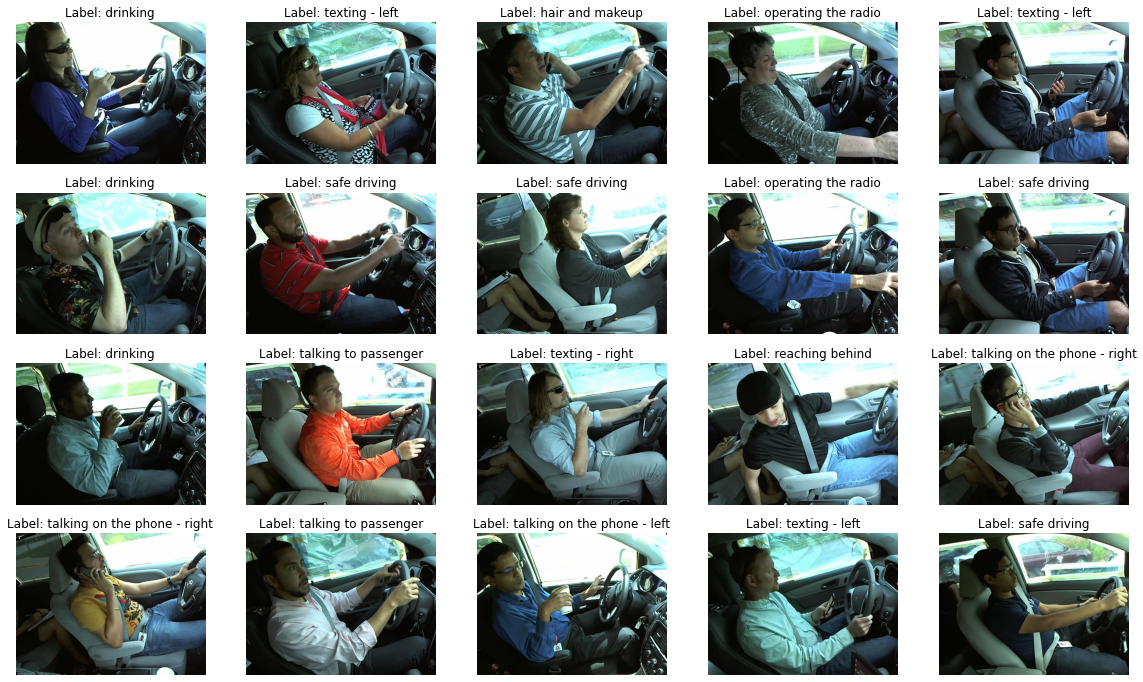

In [10]:
view_img(sampled_img_arrs, np.argmax(predictions, axis=1), n_samples, label_names)

In [11]:
predictor.delete_endpoint()